# BusMezzo - sample scripts for multiseed simulations
### (beta version) - updated 16th Dec 2020 

How the script works:

### 0. Specify input data

- working directories
- range and values of simulation [seeds]
- number and names of simulation [scenarios]
- BM parameter to be adjusted for each scenario

Before starting:
- Place the BM network files in the [network_dir].
- Leave an empty [output_dir].
- Verify the [input] parameters (above).

### 1. Perform simulation loops

Script operations - for each [scenario]:
- 1. Create a scenario dir in the [output_dir] path.
- 2. Adjust the input parameter.
- 3. Iterate over [seeds]: a) execute simulation, b) move BM output to a specific [scenario/seed] dir.

Result:
- A complete set of BM [scenario] outputs for multiple [seeds].

### 2. Process BM output

Script operations - for each [scenario]:
- 1. Summarise the data from multiple [seeds].
- 2. Analyse and process the data according to the auxiliary [functions], specified below.

Result:
- A set of BM [output summary] .csv files in each [scenario] dir.

### 3. Visualise selected BM outputs

Before starting:
- Specify the [scenario] you want to visualise within the script.

In [1]:
import os
import subprocess
import shutil
import sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 0. Specify input data

In [2]:
# working directory
working_dir = 'C:/BM_multiseed_simulations'
network_dir = 'C:/BM_multiseed_simulations/network'
output_dir = 'C:/BM_multiseed_simulations/results'

# sim. seeds
seeds = [i for i in range(40, 50)] 

# sim. scenarios
scenarios = ['no_WTW', 'WTW']

# sim. input parameter 
param_name = '\t   share_RTCI_network= '
param_values = [0.0, 1.0]
param_line = 86

In [3]:
# aux functions 

def replace_line(file_name, line_no, new_text):
    lines = open(file_name, 'r').readlines()
    lines[line_no] = new_text + '\n'

    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

## 1. Perform simulation loops

In [4]:
# (1.) create parent dir for each scenario #

# warning: this will raise an error if the output dir already exists
for scenario in scenarios:
    path = os.path.join(output_dir, scenario)
    os.mkdir(path)       

In [5]:
# then, for each scenario:
for n, scenario in enumerate(scenarios):
    print (n, scenario)

0 no_WTW
1 WTW


In [6]:
# then, for each scenario:
for n, scenario in enumerate(scenarios):
    
    # (2.) adjust input parameter #
    param_file = os.path.join(network_dir, 'parameters.dat')
    replace_line(param_file, param_line, ''.join([param_name, str(param_values[n])]))
    
    # iterate over sim. seeds:
    for i in seeds:
        
        # (3.) run BM simulations #
        sim_cmd = ' '.join(['cd', network_dir, '&& mezzo_s.exe masterfile.mezzo 1', str(i)])
        subprocess.run(sim_cmd, shell = True)
        
        # (4) create output dir for a given seed #
        dst_dir = os.path.join(output_dir, scenario, '_'.join(['seed', str(i)]))
        os.mkdir(dst_dir)
        
        # (5.) cut-and-paste BM outputs into output dir #
        output_files = [o_file for o_file in os.listdir(network_dir) if os.path.isfile(os.path.join(network_dir,o_file)) and 'o_' in o_file]
        output_files.remove('mezzo_s.exe')
        
        for o_file in output_files:
            src_dir = os.path.join(network_dir, o_file)
            shutil.move(src_dir, dst_dir)

## 2. BM output processing

### aux functions for output analysis

In [7]:
### (a.) passenger welfare ###

def analyse_pass_welfare (results_seed_dir):
    # !!! WT and IVT welfare ONLY
    
    # read input
    in_sel_paths = pd.read_csv(os.path.join(results_seed_dir, 'o_selected_paths.dat'), header = None, escapechar='{')
    aux_in_sel_paths = in_sel_paths[0].str.split('\t', expand = True)
    sel_paths_cols = aux_in_sel_paths.iloc[0,0:14]
    in_user_welfare = pd.DataFrame(aux_in_sel_paths.values[1:,0:14], columns = sel_paths_cols)
    
    # convert necessary attributes to numerical dtypes
    convert_dict = {'Total_waiting_time': float,
                   'Total_waiting_time_due_to_denied_boarding': float,
                   'Total_in_vehicle_time': float,
                   'Total_weighted_in_vehicle_time': float}
    aux_user_welfare = in_user_welfare.astype(convert_dict)
    
    # calculate MEAN values

    # group by origin stop
    # round to [mins]
    mean_user_welfare = aux_user_welfare.groupby('Origin_stop_name').mean()
    mean_user_welfare.sort_index(ascending = True, inplace = True)
    mean_user_welfare = (mean_user_welfare / 60.0).round(2)

    # calc WT welfares
    mean_user_welfare['WT_welfare'] = mean_user_welfare['Total_waiting_time'] * 2.0 + mean_user_welfare['Total_waiting_time_due_to_denied_boarding'] * 7.0
    mean_user_welfare['WT_denied_welfare'] = mean_user_welfare['Total_waiting_time_due_to_denied_boarding'] * 7.0
    mean_user_welfare.rename(columns = {'Total_waiting_time': 'tt_wt',
                             'Total_waiting_time_due_to_denied_boarding': 'tt_wt_denied',
                             'Total_in_vehicle_time': 'tt_ivt',
                             'Total_weighted_in_vehicle_time': 'IVT_welfare'}, inplace = True)
    mean_user_welfare[['tt_wt', 'tt_wt_denied', 'tt_ivt', 'WT_welfare', 'WT_denied_welfare', 'IVT_welfare']]
    mean_user_welfare['TOTAL_tt'] = mean_user_welfare['tt_wt'] + mean_user_welfare['tt_wt_denied'] + mean_user_welfare['tt_ivt']
    mean_user_welfare['TOTAL_welfare'] = mean_user_welfare['WT_welfare'] + mean_user_welfare['IVT_welfare']

    # count no. of users
    aux_no_users = aux_user_welfare.groupby('Origin_stop_name').count()
    aux_out_user_welfare = mean_user_welfare.merge(aux_no_users['Passenger_ID'], how = 'left', on = 'Origin_stop_name')
    aux_out_user_welfare.index.name = 'Origin_stop - MEAN [mins]'
    aux_out_user_welfare.rename(columns = {'Passenger_ID': 'No_passengers'}, inplace = True)

    # produce output df
    aux_user_welfare = aux_out_user_welfare[['No_passengers','WT_welfare','WT_denied_welfare','IVT_welfare','TOTAL_welfare']]

    # add sum over all stops
    aux_user_welfare.loc['line_TOTAL']= aux_user_welfare.sum(numeric_only=True, axis=0)
    
    return aux_user_welfare

In [8]:
### (b.) passenger IVT experience at each line segment ###

def analyse_onboard_experience (results_seed_dir):

    # read input df
    headers_list = ['pass_ID', 'orig_ID', 'dest_ID', 'line_ID', 'trip_ID', 'from_stop', 'to_stop', 'ivt_sched', 'ivt_actual', 'crowding_factor']
    in_onboard_exp = pd.read_csv(os.path.join(results_seed_dir, 'o_passenger_onboard_experience.dat'), names = headers_list, sep = '\t')

    # calc weighted IVT
    convert_crowding_coeff = {1.6: 1.5, 2.0: 1.8}
    in_onboard_exp.replace({'crowding_factor': convert_crowding_coeff}, inplace = True)
    in_onboard_exp['IVT_weighted'] = in_onboard_exp['ivt_actual'] * in_onboard_exp['crowding_factor']

    # aggregate weighted IVT in [hrs] for each line segment
    aux_segm_ivt_welfare = pd.pivot_table(in_onboard_exp, values = 'ivt_actual', index = ['to_stop'], columns = ['crowding_factor'], aggfunc = np.sum)
    aux_segm_ivt_welfare = (aux_segm_ivt_welfare / 60.0).round(1)
    aux_segm_ivt_welfare.fillna(0, inplace = True)
    aux_segm_ivt_welfare.index.name = 'to stop'

    aux_segm_ivt_welfare.columns = ['*', '**', '***', '****']
    aux_segm_ivt_welfare.columns.name = 'IVT actual [hrs] - crowding factors:'

    # add total IVT weighted at each segment
    aux_segm_ivt_welfare['TOTAL weighted IVT']= aux_segm_ivt_welfare['*'] + 1.2 * aux_segm_ivt_welfare['**'] + 1.5 * aux_segm_ivt_welfare['***'] + 1.8 * aux_segm_ivt_welfare['****'] 

    # add total sum
    aux_segm_ivt_welfare.loc['TOTAL']= aux_segm_ivt_welfare.sum(numeric_only=True, axis=0)

    return aux_segm_ivt_welfare

In [9]:
### (c.) trip loads ###

def analyse_trip_loads (results_seed_dir):

    in_trip_loads = pd.read_csv(os.path.join(results_seed_dir, 'o_segments_trip_loads.dat'), sep = '\t')
    in_trip_loads.drop(in_trip_loads.columns[-1], axis = 1, inplace = True)
    
    aux_trip_loads = in_trip_loads[['Start_stop_name', 'Line_ID', 'Trip_ID', 'Passenger_load']]
        
    # [OPTIONAL] - filter only trips with [pass] > 0
    #aux_trip_loads = aux_trip_loads[aux_trip_loads['Passenger_load'] > 0]
    
    return aux_trip_loads

In [10]:
### (d.) service headways ###

def analyse_service_headways (results_seed_dir):
    
    in_transit_data = pd.read_csv(os.path.join(results_seed_dir, 'o_transit_trajectory.dat'), sep = '\t')
    in_transit_data.drop(in_transit_data.columns[-1], axis = 1, inplace = True)
    
    # time in [mins]
    in_transit_data['Arrival/Departure_time'] = in_transit_data['Arrival/Departure_time'] / 60.0
    
    aux_trip_headways = in_transit_data[in_transit_data['Entering?'] == 0]
    
    # [OPTIONAL] filter only trips from the 30. minute onwards
    # aux_trip_headways = aux_trip_headways[aux_trip_headways['Arrival/Departure_time'] > 29.9]
    
    # sort by: (1.) Stop ID, (2.) dep time
    aux_trip_headways.sort_values(by=['Stop_ID', 'Arrival/Departure_time'], inplace = True)

    # filter only necessary columns
    aux_trip_headways = aux_trip_headways[['Stop_ID', 'Line_ID', 'Trip_ID', 'Arrival/Departure_time']]
    aux_trip_headways.rename(columns = {'Arrival/Departure_time': 'Dep_time'}, inplace = True)
    aux_trip_headways['Dep_time'] = aux_trip_headways['Dep_time'].round(1)

    # calc headway to the preceding (front) vehicle - at each stop!
    aux_trip_headways['Headways'] = (-1.0) * aux_trip_headways['Dep_time'].diff(periods = -1)
    aux_trip_headways = aux_trip_headways[aux_trip_headways['Headways'] > -0.1]
    
    return aux_trip_headways

In [11]:
### (e.) bus trajectories ###

def analyse_bus_trajectories (results_seed_dir):
    
    in_ridetime_data = pd.read_csv(os.path.join(results_seed_dir, 'o_transit_trajectory.dat'), sep = '\t')
    in_ridetime_data.drop(in_ridetime_data.columns[-1], axis = 1, inplace = True)

    # time in [mins]
    in_ridetime_data['Arrival/Departure_time'] = in_ridetime_data['Arrival/Departure_time'] / 60.0
    
    # filter out only necessary columns
    aux_ridetime_data = in_ridetime_data[['Stop_ID', 'Line_ID', 'Trip_ID', 'Entering?', 'Arrival/Departure_time']]
    
    return aux_ridetime_data

In [12]:
### (f.) general simulation summary ###

def analyse_welfare_sim_summary (results_seed_dir):

    headers_list = ['Parameter', 'Value']
    aux_sim_summary = pd.read_csv(os.path.join(results_seed_dir, 'o_passenger_welfare_summary.dat'), names = headers_list, index_col = 0, sep = '\t')

    return aux_sim_summary

### processing scripts

In [13]:
# iterate over each scenario
for analysed_scenario in scenarios:

    ###############################
    ### (2a.) passenger welfare ###
    ###############################
    
    out_set_seeds_user_welfare = list()

    for k, seed_no in enumerate(seeds):

        seed_results_dir = os.path.join(output_dir, analysed_scenario, '_'.join(['seed', str(seed_no)]))
        out_seed_user_welfare = analyse_pass_welfare(seed_results_dir)

        out_set_seeds_user_welfare.append(out_seed_user_welfare)

    # calc the output df for a given scenario
    out_scenario_user_welfare = pd.concat(out_set_seeds_user_welfare).groupby(level=0).mean()

    # save the output df as a .csv file
    out_scenario_user_welfare.to_csv(os.path.join(output_dir, analysed_scenario, 'OUT_pass_welfare.csv'))
    
    ######################################
    ### (2b.) passenger IVT experience ###
    ######################################
    
    out_set_seeds_ivt_experience = list()

    for k, seed_no in enumerate(seeds):

        seed_results_dir = os.path.join(output_dir, analysed_scenario, '_'.join(['seed', str(seed_no)]))
        out_seed_ivt_experience = analyse_onboard_experience(seed_results_dir)

        out_set_seeds_ivt_experience.append(out_seed_ivt_experience)

    # calc the output df for a given scenario
    out_scenario_ivt_experience = pd.concat(out_set_seeds_ivt_experience).groupby(level=0).mean()

    # save the output df as a .csv file
    out_scenario_ivt_experience.to_csv(os.path.join(output_dir, analysed_scenario, 'OUT_onboard_experience.csv'))
    
    ########################
    ### (2c.) trip loads ###
    ########################
    
    for k, seed_no in enumerate(seeds):

        seed_results_dir = os.path.join(output_dir, analysed_scenario, '_'.join(['seed', str(seed_no)]))
        out_seed_trip_loads = analyse_trip_loads(seed_results_dir)

        # add seed no. to pass. load column
        seed_load_colname = '_'.join(['Passenger_load', 'seed', str(seed_no)])
        out_seed_trip_loads.rename(columns = {'Passenger_load': seed_load_colname}, inplace = True)

        if k == 0:
            out_set_seeds_trip_loads = out_seed_trip_loads
        else:
            out_set_seeds_trip_loads = out_set_seeds_trip_loads.merge(out_seed_trip_loads, how = 'inner', on= ['Start_stop_name', 'Line_ID', 'Trip_ID'])

    out_set_seeds_trip_loads.set_index(['Start_stop_name', 'Line_ID', 'Trip_ID'], inplace = True)

    # calc the output df for a given scenario
    out_scenario_pass_loads = out_set_seeds_trip_loads.mean(axis=1).to_frame()
    out_scenario_pass_loads.columns = ['Passenger_load']

    # save the output df as a .csv file
    out_scenario_pass_loads.to_csv(os.path.join(output_dir, analysed_scenario, 'OUT_pass_loads.csv'))
    
    ##############################
    ### (2d.) service headways ###
    ##############################
    
    for k, seed_no in enumerate(seeds):

        seed_results_dir = os.path.join(output_dir, analysed_scenario, '_'.join(['seed', str(seed_no)]))
        out_seed_service_headways = analyse_service_headways(seed_results_dir)

        # add seed no. to dep_time and headway columns
        seed_deptime_colname = '_'.join(['Dep_time', 'seed', str(seed_no)])
        seed_headway_colname = '_'.join(['Headways', 'seed', str(seed_no)])
        out_seed_service_headways.rename(columns = {'Dep_time': seed_deptime_colname, 'Headways': seed_headway_colname}, inplace = True)

        if k == 0:
            out_set_seeds_service_headways = out_seed_service_headways
        else:
            out_set_seeds_service_headways = out_set_seeds_service_headways.merge(out_seed_service_headways, how = 'inner', on= ['Stop_ID', 'Line_ID', 'Trip_ID'])

    out_set_seeds_service_headways.set_index(['Stop_ID', 'Line_ID', 'Trip_ID'], inplace = True)

    # calc mean of odd [Dep_time] and even [Headways] columns
    out_set_seeds_service_headways = out_set_seeds_service_headways.assign(Dep_time = out_set_seeds_service_headways[out_set_seeds_service_headways.columns[::2]].mean(axis=1), Headways = out_set_seeds_service_headways[out_set_seeds_service_headways.columns[1::2]].mean(axis=1))

    # calc the output df for a given scenario
    out_scenario_service_headways = out_set_seeds_service_headways[['Dep_time', 'Headways']]

    # save the output df as a .csv file
    out_scenario_service_headways.to_csv(os.path.join(output_dir, analysed_scenario, 'OUT_service_headways.csv'))
    
    #######################################################
    # (2e.) bus trajectories - for visualisation purposes #
    #######################################################
    
    for k, seed_no in enumerate(seeds):

        seed_results_dir = os.path.join(output_dir, analysed_scenario, '_'.join(['seed', str(seed_no)]))
        out_seed_bus_trajectories = analyse_bus_trajectories(seed_results_dir)

        # add seed no. to dep_time and headway columns
        seed_time_colname = '_'.join(['Arrival/Departure_time', 'seed', str(seed_no)])
        out_seed_bus_trajectories.rename(columns = {'Arrival/Departure_time': seed_time_colname}, inplace = True)

        if k == 0:
            out_set_seeds_bus_trajectories = out_seed_bus_trajectories
        else:
            out_set_seeds_bus_trajectories = out_set_seeds_bus_trajectories.merge(out_seed_bus_trajectories, how = 'inner', on= ['Stop_ID', 'Line_ID', 'Trip_ID', 'Entering?'])

    out_set_seeds_bus_trajectories.set_index(['Stop_ID', 'Line_ID', 'Trip_ID', 'Entering?'], inplace = True)

    # calc the output df for a given scenario
    out_scenario_bus_trajectories = out_set_seeds_bus_trajectories.mean(axis=1).to_frame()
    out_scenario_bus_trajectories.columns = ['Arrival/Departure_time']
    
    ######################################
    # (2f.) aggregate simulation summary #
    ######################################
    
    # - useful for checking mean vs. std stats (total cost, mean welfare, no. of passengers) over all the simulation runs

    for k, seed_no in enumerate(seeds):

        seed_results_dir = os.path.join(output_dir, analysed_scenario, '_'.join(['seed', str(seed_no)]))
        out_seed_summary = analyse_welfare_sim_summary(seed_results_dir)

        # add seed no. to output column
        seed_no_colname = '_'.join(['Result', 'seed', str(seed_no)])
        out_seed_summary.rename(columns = {'Value': seed_no_colname}, inplace = True)

        if k == 0:
            out_set_seeds_summary = out_seed_summary
        else:
            out_set_seeds_summary = out_set_seeds_summary.merge(out_seed_summary, how = 'inner', on = 'Parameter')

    # calc mean
    summary_mean = out_set_seeds_summary.mean(axis=1).to_frame()
    summary_mean.columns = ['SUMMARY_mean']

    # calc std
    summary_std = out_set_seeds_summary.std(axis=1).to_frame()
    summary_std.columns = ['SUMMARY_std']

    # calc the output df for a given scenario
    out_scenario_summary = summary_mean.merge(summary_std, how = 'inner', on = 'Parameter').round(1)

    # save the output df as a .csv file
    out_scenario_summary.to_csv(os.path.join(output_dir, analysed_scenario, 'OUT_sim_welfare_summary.csv'))

C:\Users\KSK\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\KSK\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
# plot sample dfs

In [15]:
out_scenario_user_welfare

,No_passengers,WT_welfare,WT_denied_welfare,IVT_welfare,TOTAL_welfare
Origin_stop - MEAN [mins],,,,,
A,275.8,8.916,0.000,69.036,77.952
B,304.1,8.770,0.000,64.544,73.314
C,301.9,7.946,0.000,60.179,68.125
D,311.6,7.470,0.000,59.128,66.598
E,310.1,9.748,0.000,60.957,70.705
F,307.5,9.408,0.056,57.368,66.776
G,198.5,8.522,0.056,47.192,55.714
H,206.2,10.754,2.030,38.385,49.139
I,191.6,17.104,6.216,29.148,46.252


In [16]:
out_scenario_ivt_experience

IVT actual [hrs] - crowding factors:,*,**,***,****,TOTAL weighted IVT
to stop,,,,,
2,1783.04,0.00,0.00,0.00,1783.040
3,3655.72,57.03,0.00,0.00,3724.156
4,4193.91,1329.39,8.08,0.00,5801.298
5,2314.42,4833.90,340.52,0.00,8625.880
6,1692.67,6303.28,1262.80,97.81,11326.864
7,1830.14,6688.40,1392.86,1233.90,14166.530
8,1716.95,6688.49,1297.99,1714.12,14775.539
9,1709.21,7137.06,887.44,2843.58,16723.286
10,1695.38,7528.10,748.95,3501.46,18155.153


In [17]:
out_scenario_pass_loads

,,,Passenger_load
Start_stop_name,Line_ID,Trip_ID,
A,1,101,0.0
B,1,101,0.0
C,1,101,0.0
D,1,101,0.0
E,1,101,0.0
...,...,...,...
C,2,212,0.5
D,2,212,0.5
E,2,212,0.5


In [18]:
out_scenario_service_headways

Dep_time  Headways
Stop_ID Line_ID Trip_ID                    
1       1       101          0.60      4.50
        2       201          5.10      5.50
        1       102         10.60      4.50
        2       202         15.10      5.50
        1       103         20.60      4.50
...                           ...       ...
12      2       207        135.33      3.03
        1       108        138.36      1.62
        2       208        139.98      3.32
        1       109        143.30      2.13
        2       209        145.43      3.98

[261 rows x 2 columns]

## 3. BM output visualisation
### sample charts - for a specified scenario:

In [19]:
analysed_scenario = 'WTW'

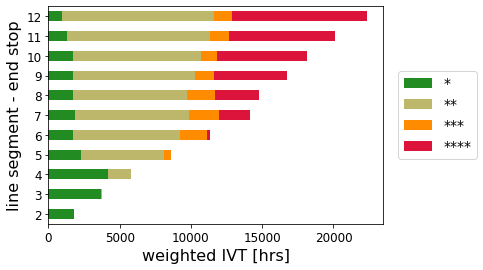

In [20]:
###########################################
# (3b.) weighted IVT at each line segment #
###########################################

# remove total sums
plot_ivt_experience = out_scenario_ivt_experience.iloc[:-1,:-1]

# multiply by crowding coeff to obtain weighted IVT
crowding_coeffs = [1.0, 1.2, 1.5, 1.8]
plot_ivt_experience = plot_ivt_experience.multiply(crowding_coeffs, axis = 1)

crowding_colours = ['forestgreen', 'darkkhaki', 'darkorange', 'crimson']

fig1, ax1 = plt.subplots()

plot_ivt_experience.plot(kind = 'barh', stacked = True, color = crowding_colours, fontsize = 12, ax = ax1)
ax1.set_xlabel('weighted IVT [hrs]', fontsize = 16)
ax1.set_ylabel('line segment - end stop', fontsize = 16)

ax1.legend(bbox_to_anchor = (1.3,0.5), loc = 'center right', fontsize = 14)

plt.show()

C:\Users\KSK\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\KSK\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


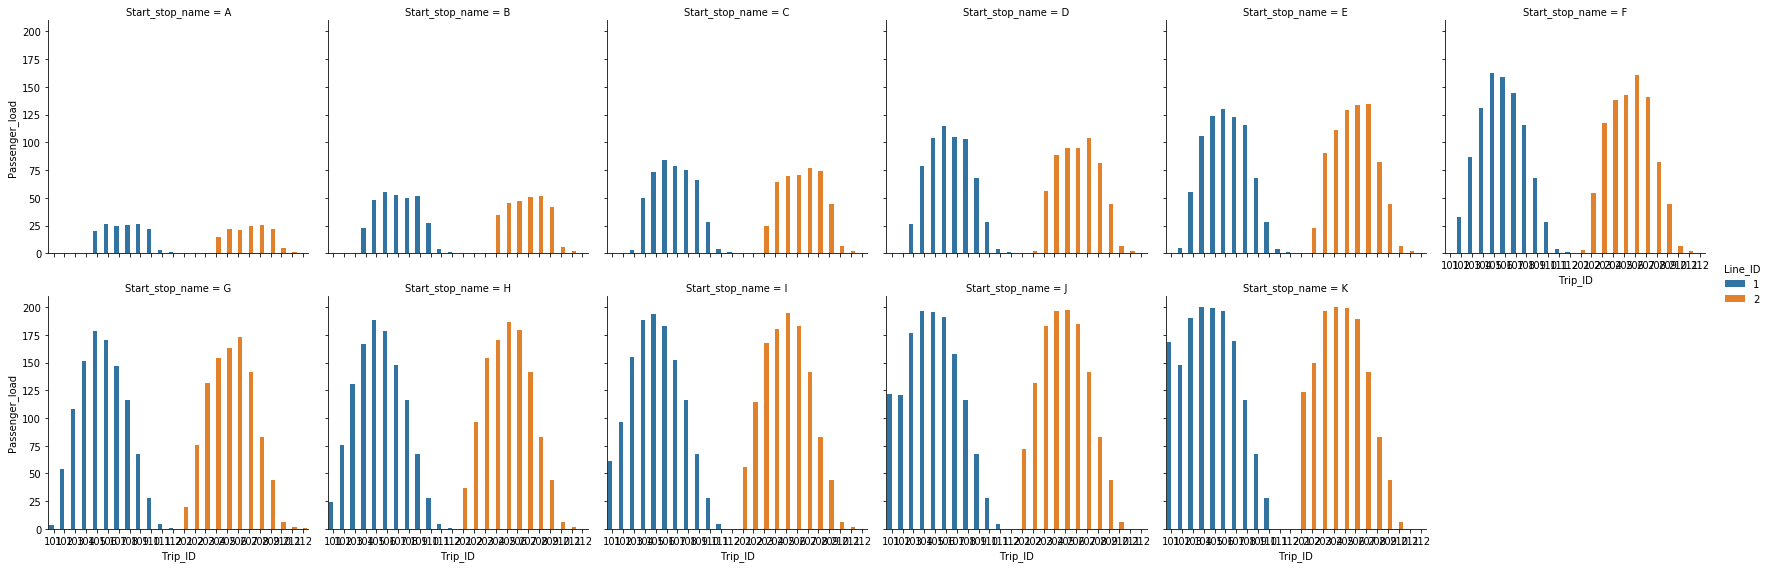

In [21]:
#################################################
# (3c.) distribution of line loads at each stop #
#################################################


plot_pass_loads = out_scenario_pass_loads.reset_index()
sns.factorplot(x = 'Trip_ID', y = 'Passenger_load', hue = 'Line_ID', col = 'Start_stop_name', col_wrap = 6, data = plot_pass_loads, kind = 'bar', size = 4)

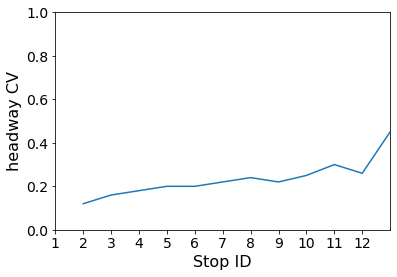

In [22]:
##########################################################
# (3d.) coefficient of headway variation along the stops #
##########################################################

mean_headways = out_scenario_service_headways.groupby('Stop_ID').mean().round(1)
std_headways = out_scenario_service_headways.groupby('Stop_ID').std().round(1)

# C. merge both dfs and rename columns
out_trip_headways = mean_headways.merge(std_headways, how = 'inner', on = 'Stop_ID', left_index = True)
out_trip_headways = out_trip_headways[['Headways_x', 'Headways_y']]
out_trip_headways.rename(columns = {'Headways_x': 'mean_headway',
                                    'Headways_y': 'std_headway'}, inplace = True)

# coefficient of headway variation
out_trip_headways['CV_headway'] = (out_trip_headways['std_headway'] / out_trip_headways['mean_headway']).round(2)

# plot coefficient of headway variation at stops
fig2, ax2 = plt.subplots()

ax2 = out_trip_headways['CV_headway'].plot(fontsize = 14)

ax2.set_xticks(range(len(out_trip_headways)))
ax2.set_xticklabels([item for item in out_trip_headways.index.tolist()])
ax2.set_ylim(0, 1.0)

ax2.set_xlabel('Stop ID', fontsize = 16)
ax2.set_ylabel('headway CV', fontsize = 16)

plt.show()

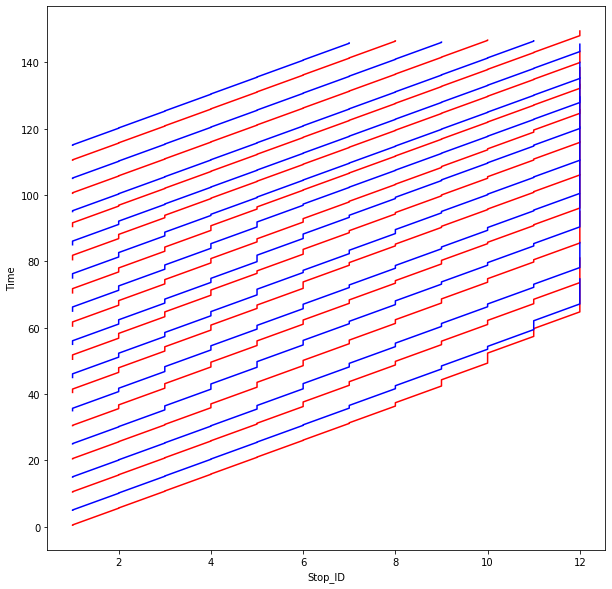

In [23]:
#####################################
# (3e.) space-time bus trajectories #
#####################################

aux_out_scenario_bus_trajectories = out_scenario_bus_trajectories.reset_index()

# add line colours
aux_out_scenario_bus_trajectories['line_colors'] = np.where(aux_out_scenario_bus_trajectories['Line_ID'] == 1, 'r', 'b').astype(str)

PT_trajectories_data = aux_out_scenario_bus_trajectories.groupby('Trip_ID')

for name, entry in PT_trajectories_data:
    plt.plot(entry['Stop_ID'], entry['Arrival/Departure_time'], label = name, color = entry['line_colors'].iloc[1])
    
plt.xlabel('Stop_ID')
plt.ylabel('Time')

#plt.legend(entry['Line_ID'], bbox_to_anchor = (1.3,0.5), loc = 'center right', fontsize = 12)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 24
plt.gcf().set_size_inches(10, 10)

plt.show()